In [1]:
from herbert_emotion_classifier.wordnet_dataset import EmotionsInTextDataset
from herbert_emotion_classifier.baseline_dataset import EmotionsInTextBaselineDataset 
from herbert_emotion_classifier.model import HerbertEmotionClassifier
from herbert_emotion_classifier.datamodule import EmotionsInTextDatamodule

from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import WandbLogger

In [2]:
model = HerbertEmotionClassifier()

In [3]:
train_ds = EmotionsInTextDataset()
val_ds = EmotionsInTextBaselineDataset()

In [4]:
dm = EmotionsInTextDatamodule(128, train_ds, val_ds)

In [5]:
x, y = next(iter(dm.val_dataloader()))

In [6]:
# logger = WandbLogger(name="unet_resnet50",project="pst_segmentation")

seed_everything(42)

trainer = Trainer(max_epochs=100,
                  gpus=1,
                  deterministic=True,
                  accumulate_grad_batches=4,
                  checkpoint_callback=False,
                  callbacks=[EarlyStopping(monitor='val/loss')],
                  logger=False
                  )

trainer.fit(model, dm)

model.eval()
a=1
# model.freeze()


GPU available: True, used: True
I1217 22:10:01.507094 139917831157568 distributed.py:49] GPU available: True, used: True
TPU available: False, using: 0 TPU cores
I1217 22:10:01.507946 139917831157568 distributed.py:49] TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
I1217 22:10:01.508467 139917831157568 accelerator_connector.py:402] LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type             | Params
------------------------------------------------
0 | criterion  | CrossEntropyLoss | 0     
1 | model      | RobertaModel     | 124 M 
2 | classifier | Sequential       | 230 K 
I1217 22:10:02.838551 139917831157568 lightning.py:1295] 
  | Name       | Type             | Params
------------------------------------------------
0 | criterion  | CrossEntropyLoss | 0     
1 | model      | RobertaModel     | 124 M 
2 | classifier | Sequential       | 230 K 


In [19]:
from herbert_emotion_classifier.predict import predict
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

In [11]:
predictions, true_labels = predict(model, dm.val_dataloader(), "cuda")

In [15]:
class_names = ['neutralne', 'oczekiwanie', 'podziw', 'radosc', 'smutek', 'strach', 'wstret', 'zaskoczenie', 'zlosc']

<AxesSubplot:>

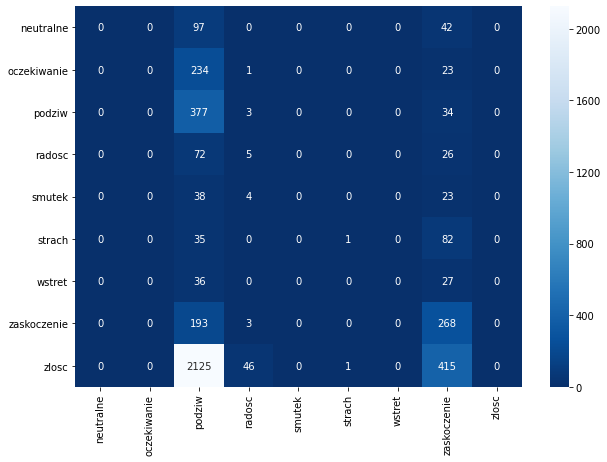

In [21]:
cm = confusion_matrix(true_labels, predictions)
df_cm = pd.DataFrame(cm, index = [i for i in class_names],
                  columns = [i for i in class_names])
plt.figure(figsize = (10,7))

sn.heatmap(df_cm, cmap="Blues_r", annot=True, fmt="d")

In [23]:
print(classification_report(true_labels, predictions))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       139
         1.0       0.00      0.00      0.00       258
         2.0       0.12      0.91      0.21       414
         3.0       0.08      0.05      0.06       103
         4.0       0.00      0.00      0.00        65
         5.0       0.50      0.01      0.02       118
         6.0       0.00      0.00      0.00        63
         7.0       0.29      0.58      0.38       464
         8.0       0.00      0.00      0.00      2587

   micro avg       0.15      0.15      0.15      4211
   macro avg       0.11      0.17      0.07      4211
weighted avg       0.06      0.15      0.06      4211



/anaconda/envs/jupyterhub/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda/envs/jupyterhub/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda/envs/jupyterhub/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
